In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmetrics import MeanSquaredError
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from tqdm.auto import tqdm
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from src import model as modeling
from src import sim_dataset

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [3]:
class CFG:
    model_name="bert-base-uncased"
    val_size=0.25
    max_len=64
    batch_size=4
    epochs=3
    lr=2e-5
    max_lr=1e-3
    steps_per_epoch=None
    pct_start=0.3
    div_factor=1e+2
    final_div_factor=1e+4
    accumulate=1
    patience=3
    monitor="val_loss"
    seed=42
    debug=True

In [4]:
CFG.__dict__

mappingproxy({'__module__': '__main__',
              'model_name': 'bert-base-uncased',
              'val_size': 0.25,
              'max_len': 64,
              'batch_size': 4,
              'epochs': 3,
              'lr': 2e-05,
              'max_lr': 0.001,
              'steps_per_epoch': None,
              'pct_start': 0.3,
              'div_factor': 100.0,
              'final_div_factor': 10000.0,
              'accumulate': 1,
              'patience': 3,
              'monitor': 'val_loss',
              'seed': 42,
              'debug': True,
              '__dict__': <attribute '__dict__' of 'CFG' objects>,
              '__weakref__': <attribute '__weakref__' of 'CFG' objects>,
              '__doc__': None})

In [5]:
if CFG.debug == True:
    train_data = train_data.iloc[:200]

scores = train_data.score.values
train_data.drop("score", inplace=True, axis=1)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, scores,
                                                                 stratify=scores,
                                                                 test_size=CFG.val_size,
                                                                 random_state=CFG.seed)

train_data["score"] = train_labels
val_data["score"] =  val_labels

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
train_dataset = sim_dataset.PhraseSimilarityDataset(train_data, tokenizer, CFG.max_len)

val_dataset = sim_dataset.PhraseSimilarityDataset(val_data, tokenizer, CFG.max_len)
test_dataset = sim_dataset.PhraseSimilarityTestset(test_data, tokenizer, CFG.max_len)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [7]:
steps_per_epoch = len(train_dataloader)
print(f"steps_per_epoch: {steps_per_epoch}")
total_steps = steps_per_epoch * CFG.epochs
print(f"total_steps: {total_steps}")

num_warmups = int(total_steps * 0.1)
print(f"num_warmups: {num_warmups}")

num_decreases = total_steps - num_warmups
print(f"num_decreases: {num_decreases}")

steps_per_epoch: 38
total_steps: 114
num_warmups: 11
num_decreases: 103


In [8]:
logger = CSVLogger(save_dir='./', name=CFG.model_name.split('/')[-1]+'_log_test')
logger.log_hyperparams(CFG.__dict__)

In [9]:
checkpoint_callback = ModelCheckpoint(monitor=CFG.monitor,
                                     save_top_k=1,
                                     save_last=True,
                                     save_weights_only=True,
                                     filename="{epoch:02d}-{valid_loss:.4f}-{valid_acc:.4f}",
                                     verbose=False,
                                     mode="min")

In [10]:
early_stop_callback = EarlyStopping(monitor=CFG.monitor,
                                   patience=CFG.patience,
                                   verbose=False,
                                   mode="min")

In [11]:
model = modeling.PhraseSimilarityModelImpl(CFG.model_name)
criterion = nn.HuberLoss(reduction='mean', delta=1.0)
metric = MeanSquaredError()
driver = modeling.PhraseSimilarityModel(model=model,
                                   lr=CFG.lr,
                                   num_warmups=num_warmups,
                                   num_decreases=num_decreases,
                                   criterion=criterion,
                                   metric=metric)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


OK init


In [12]:
driver.configure_optimizers()

OK inside configure
1e-06
Scheduler learning rate2.7272727272727272e-06


([Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      initial_lr: 2e-05
      lr: 2.7272727272727272e-06
      maximize: False
      weight_decay: 0
  )],
 [{'scheduler': <src.lr_scheduler.WarmupLRScheduler at 0x7f9bd11cc400>,
   'interval': 'step',
   'frequency': 1}])

In [13]:
trainer = Trainer(
    max_epochs=CFG.epochs,
    accumulate_grad_batches=CFG.accumulate,
    callbacks=[checkpoint_callback, early_stop_callback], 
    logger=logger,
    weights_summary='top',
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(driver, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | PhraseSimilarityModelImpl | 109 M 
1 | criterion | HuberLoss                 | 0     
2 | metric    | MeanSquaredError          | 0     
--------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.932   Total estimated model params size (MB)
/anaconda/envs/USPTO/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:404: UserWarning: Skipping '__dict__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")
/anaconda/envs/USPTO/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:404: UserWarning: Skipping '__weakref__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")


OK inside configure
1e-06
Scheduler learning rate2.7272727272727272e-06


Sanity Checking: 0it [00:00, ?it/s]

/anaconda/envs/USPTO/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/anaconda/envs/USPTO/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/anaconda/envs/USPTO/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_

Training: 0it [00:00, ?it/s]

2.7272727272727272e-06
4.454545454545455e-06
6.181818181818182e-06
7.909090909090909e-06
9.636363636363638e-06
1.1363636363636365e-05
1.3090909090909092e-05
1.4818181818181819e-05
1.6545454545454548e-05
1.8272727272727275e-05
2e-05
1.9815533980582525e-05
1.9631067961165052e-05
1.9446601941747576e-05
1.92621359223301e-05
1.9077669902912623e-05
1.889320388349515e-05
1.8708737864077673e-05
1.8524271844660197e-05
1.833980582524272e-05
1.8155339805825244e-05
1.797087378640777e-05
1.7786407766990294e-05
1.7601941747572818e-05
1.741747572815534e-05
1.7233009708737865e-05
1.7048543689320392e-05
1.6864077669902915e-05
1.667961165048544e-05
1.6495145631067962e-05
1.6310679611650486e-05
1.612621359223301e-05
1.5941747572815536e-05
1.575728155339806e-05
1.5572815533980583e-05
1.5388349514563107e-05
1.5203883495145634e-05
1.5019417475728157e-05


Validation: 0it [00:00, ?it/s]

1.4834951456310681e-05
1.4650485436893206e-05
1.446601941747573e-05
1.4281553398058255e-05
1.4097087378640779e-05
1.3912621359223302e-05
1.3728155339805827e-05
1.3543689320388351e-05
1.3359223300970876e-05
1.31747572815534e-05
1.2990291262135925e-05
1.2805825242718448e-05
1.2621359223300972e-05
1.2436893203883497e-05
1.225242718446602e-05
1.2067961165048546e-05
1.188349514563107e-05
1.1699029126213595e-05
1.1514563106796118e-05
1.1330097087378642e-05
1.1145631067961167e-05
1.096116504854369e-05
1.0776699029126216e-05
1.059223300970874e-05
1.0407766990291263e-05
1.0223300970873788e-05
1.0038834951456312e-05
9.854368932038837e-06
9.66990291262136e-06
9.485436893203886e-06
9.30097087378641e-06
9.116504854368933e-06
8.932038834951458e-06
8.747572815533982e-06
8.563106796116505e-06
8.37864077669903e-06
8.194174757281554e-06
8.009708737864079e-06


Validation: 0it [00:00, ?it/s]

7.825242718446603e-06
7.640776699029128e-06
7.4563106796116505e-06
7.271844660194175e-06
7.087378640776699e-06
6.902912621359224e-06
6.718446601941748e-06
6.5339805825242724e-06
6.349514563106797e-06
6.16504854368932e-06
5.980582524271845e-06
5.796116504854369e-06
5.6116504854368935e-06
5.427184466019418e-06
5.242718446601942e-06
5.058252427184466e-06
4.87378640776699e-06
4.689320388349515e-06
4.504854368932039e-06
4.320388349514563e-06
4.135922330097088e-06
3.951456310679612e-06
3.7669902912621365e-06
3.58252427184466e-06
3.3980582524271844e-06
3.213592233009709e-06
3.029126213592233e-06
2.8446601941747576e-06
2.660194174757282e-06
2.475728155339806e-06
2.29126213592233e-06
2.1067961165048543e-06
1.9223300970873787e-06
1.737864077669903e-06
1.5533980582524272e-06
1.3689320388349514e-06
1.1844660194174758e-06
1e-06


Validation: 0it [00:00, ?it/s]

In [15]:
driver.sch

In [17]:
len(driver.lrs)

114

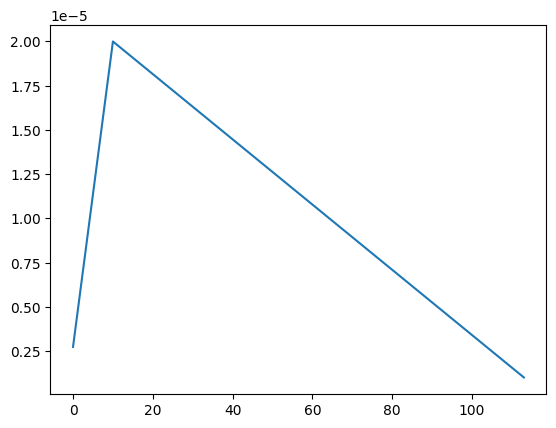

In [16]:
plt.plot(driver.lrs)
plt.show()